In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Monte Carlo Option 1

In [53]:
def generate_panel(n_units=100, n_periods=10, treatment_start=5):
    """
    Generate a balanced panel with staggered treatment adoption.
    """
    # Create panel structure
    units = np.arange(n_units)
    periods = np.arange(n_periods)
    panel = pd.DataFrame([(u, t) for u in units for t in periods], 
                         columns=['unit', 'time'])
    
    # Assign treatment timing (staggered adoption)
    treatment_times = np.random.randint(treatment_start, n_periods, size=n_units)
    unit_treats = pd.DataFrame({'unit': units, 'treat_time': treatment_times})
    panel = panel.merge(unit_treats, on='unit')
    
    # Create treatment indicator
    panel['D'] = (panel['time'] >= panel['treat_time']).astype(int)
    
    # Generate heterogeneous treatment effects
    panel['tau'] = np.where(panel['D'] == 1,
                            2 + 0.5 * panel['time'] + np.random.normal(0, 0.1, len(panel)),
                            0)
    
    # Generate outcome with unit FE, time FE and treatment effects
    panel['unit_fe'] = np.random.normal(0, 1, n_units)[panel['unit']]
    panel['time_fe'] = 0.2 * panel['time']
    panel['epsilon'] = np.random.normal(0, 1, len(panel))
    panel['Y'] = panel['unit_fe'] + panel['time_fe'] + panel['tau'] + panel['epsilon']
    
    return panel

In [55]:
def estimate_twfe(data):
    """
    Estimate two-way fixed effects regression with proper handling of dummy variables.
    Returns the coefficient on the treatment indicator.
    """
    # Create unit and time dummies
    unit_dummies = pd.get_dummies(data['unit'], prefix='unit')
    time_dummies = pd.get_dummies(data['time'], prefix='time')
    
    # Drop one category from each set of dummies to avoid collinearity
    unit_dummies = unit_dummies.iloc[:, :-1]  # Drop last unit
    time_dummies = time_dummies.iloc[:, :-1]  # Drop last time period
    
    # Combine all variables: note that I put 'D' as the last column
    X = pd.concat([unit_dummies, time_dummies, data['D']], axis=1)
    y = data['Y']
    
    # Add constant term; note that pd.Series(1, index=X.index) creates a series of 1's.
    X = pd.concat([pd.Series(1, index=X.index, name='const'), X], axis=1)
    
    # Convert X and y to numpy arrays
    X_np = X.values
    y_np = y.values
    
    # Estimate OLS using formula 
    beta = np.linalg.inv(X_np.T @ X_np) @ (X_np.T @ y_np)
    
    # Because we concatenated the treatment indicator as the last column, the coefficient on D is at position -1.
    return beta[-1]

In [57]:
# Run simulation
np.random.seed(123)
n_sims = 1000
estimates = []
true_effects = []

for i in range(n_sims):
    data = generate_panel()
    est = estimate_twfe(data)
    estimates.append(est)
    
    # Calculate true average treatment effect for this sample
    true_ate = data.loc[data['D'] == 1, 'tau'].mean()
    true_effects.append(true_ate)

In [58]:
# Analyze results
estimates = np.array(estimates)
true_effects = np.array(true_effects)
bias = np.mean(estimates - true_effects)

print(f"Average TWFE estimate: {np.mean(estimates):.3f}")
print(f"Average true effect: {np.mean(true_effects):.3f}")
print(f"Average bias: {bias:.3f}")


Average TWFE estimate: 5.257
Average true effect: 5.835
Average bias: -0.577


In [59]:
# Also look at the distribution of weights in one sample
data = generate_panel()
treated_data = data[data['D'] == 1]
print("\nDistribution of treatment effects in one sample:")
print(treated_data.groupby('time')['tau'].mean())


Distribution of treatment effects in one sample:
time
5    4.497215
6    5.019483
7    5.506498
8    5.995838
9    6.515185
Name: tau, dtype: float64


### Monte Carlo Option 2

In [43]:
def create_simple_panel():
    """
    Create a simple panel data set with 2 units and 3 time periods.
    
    - Unit A is treated starting in period 2.
    - Unit B is treated starting in period 3.
    The outcome Y reflects the treatment effect:
      - Unit A: tau = 2 at time 2 and tau = 4 at time 3.
      - Unit B: tau = 3 at time 3.
    """
    data = pd.DataFrame([
        # Unit A observations
        {'unit': 'A', 'time': 1, 'D': 0, 'Y': 0},
        {'unit': 'A', 'time': 2, 'D': 1, 'Y': 2},  # Treatment effect = 2
        {'unit': 'A', 'time': 3, 'D': 1, 'Y': 4},  # Treatment effect = 4
        # Unit B observations
        {'unit': 'B', 'time': 1, 'D': 0, 'Y': 0},
        {'unit': 'B', 'time': 2, 'D': 0, 'Y': 0},
        {'unit': 'B', 'time': 3, 'D': 1, 'Y': 3},  # Treatment effect = 3
    ])
    return data

In [45]:
def plot_panel(data):
    """
    Plot outcomes over time for each unit and mark the time at which treatment begins.
    """
    plt.figure(figsize=(10, 6))
    units = data['unit'].unique()
    # Define line styles for clarity
    line_styles = {'A': '-', 'B': '--'}
    
    for unit in units:
        unit_data = data[data['unit'] == unit]
        plt.plot(unit_data['time'], unit_data['Y'], marker='o', 
                 label=f'Unit {unit}', linestyle=line_styles.get(unit, '-'))
    
    # Mark treatment initiation for each unit based on the first period D==1 for each unit
    for unit in units:
        treat_time = data[(data['unit'] == unit) & (data['D'] == 1)]['time'].min()
        if pd.notnull(treat_time):
            plt.axvline(x=treat_time, color='gray', linestyle=':', 
                        label=f'Unit {unit} treated (t={treat_time})')
    
    plt.xlabel('Time')
    plt.ylabel('Outcome (Y)')
    plt.title('Simple Example of Treatment Effects')
    plt.legend()
    plt.grid(True)
    plt.show()

In [47]:
def get_twfe_weights(data):
    """
    Calculate the implicit weights on each observation in a TWFE regression.
    
    The design matrix includes:
      - Unit fixed effects (dummy variables)
      - Time fixed effects (dummy variables)
      - The treatment indicator D (placed as the last column)
    
    Returns:
      A DataFrame with the unit, time, treatment indicator, and computed weight.
    """
    # Create dummies for units and time
    unit_dummies = pd.get_dummies(data['unit'], prefix='unit')
    time_dummies = pd.get_dummies(data['time'], prefix='time')
    
    # Concat the dummy variables and the treatment
    X = pd.concat([unit_dummies, time_dummies, data['D']], axis=1)
    
    # Compute the projection matrix: P = X (X'X)^{-1} X'
    XtX_inv = np.linalg.inv(X.T @ X)
    P = X.values @ XtX_inv @ X.values.T
    
    # Extract the weights corresponding to the treatment indicator.
    # We assume that the treatment column is the last one in X.
    weights = P[:, -1]
    
    return pd.DataFrame({
        'unit': data['unit'],
        'time': data['time'],
        'D': data['D'],
        'weight': weights
    })

In [49]:
def compute_twfe_estimate(weights, true_effects):
    """
    Merge the computed weights with true treatment effects for treated observations,
    and calculate the TWFE estimated treatment effect.
    
    Args:
      weights: DataFrame with columns ['unit', 'time', 'D', 'weight'].
      true_effects: DataFrame with columns ['unit', 'time', 'tau'] containing the
                    true treatment effect for treated observations.
    
    Returns:
      The TWFE estimate computed as the sum over treated observations of (weight * tau).
    """
    # Merge weights with true treatment effects for treated observations only
    merged = weights[weights['D'] == 1].merge(true_effects, on=['unit', 'time'])
    twfe_estimate = (merged['weight'] * merged['tau']).sum()
    return twfe_estimate, merged[['unit', 'time', 'weight', 'tau']]


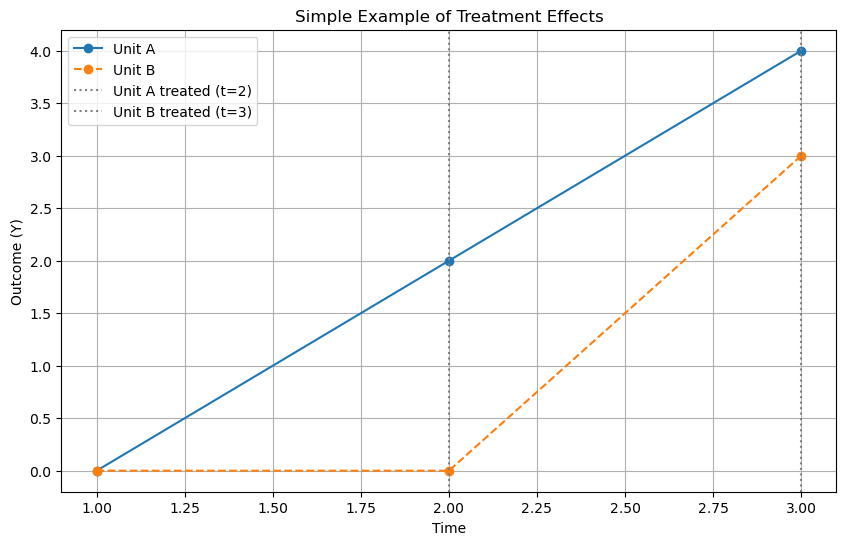


Implicit weights in TWFE estimation:
  unit  time  D        weight
0    A     1  0 -2.500000e-01
1    A     2  1 -4.440892e-16
2    A     3  1  2.500000e-01
3    B     1  0  5.000000e-01
4    B     2  0  2.500000e-01
5    B     3  1  1.000000e+00


In [51]:
# Create and plot the panel data
data = create_simple_panel()
plot_panel(data)

# Compute the implicit TWFE weights
weights = get_twfe_weights(data)
print("\nImplicit weights in TWFE estimation:")
print(weights)

# Define the true treatment effects for the treated observations
true_effects = pd.DataFrame([
    {'unit': 'A', 'time': 2, 'tau': 2},
    {'unit': 'A', 'time': 3, 'tau': 4},
    {'unit': 'B', 'time': 3, 'tau': 3}
])

In [40]:
# Compute the TWFE estimate based on the weights and true treatment effects
twfe_est, weighted_effects = compute_twfe_estimate(weights, true_effects)
print("\nContribution of each treatment effect:")
print(weighted_effects)
print(f"\nTWFE estimate: {twfe_est:.2f}")



Contribution of each treatment effect:
  unit  time        weight  tau
0    A     2 -4.440892e-16    2
1    A     3  2.500000e-01    4
2    B     3  1.000000e+00    3

TWFE estimate: 4.00
